# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
# Camera calibration

First, I extract object points `objpoints` and image points `imgpoints` using chessboard images for camera calibration. Then I compute the matrix `mtx` and distortion coefficients `dist` to test undistortion on an image. Last, I save the calibration result as an pickle file for later usage. [[ref #11]](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/5415176a-d615-49af-8535-53a385768a23)

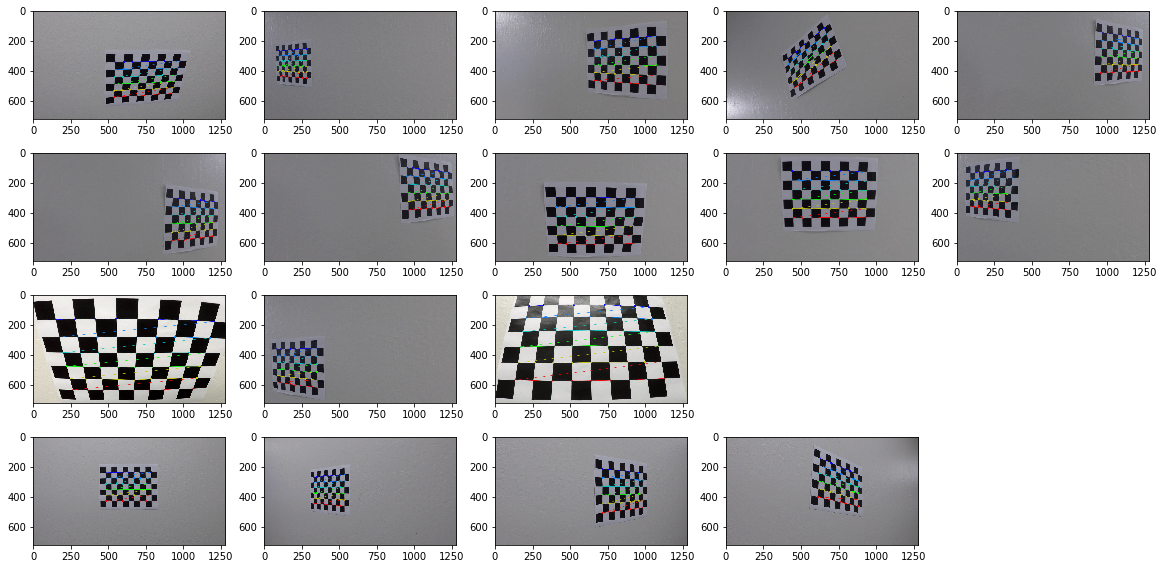

In [1]:
import numpy as np
import math
import glob
import pickle
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of file names of calibration images
fns = glob.glob('camera_calibration/calibration_images/calibration*.jpg')

# Step through the list and search for chessboard corners
n_x = 9
n_y = 6

n_fns = len(fns)
n_col = 5
n_row = math.ceil(n_fns/n_col)
plt.figure(n_fns, figsize=(20, 10))

for index, fname in enumerate(fns):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (n_x,n_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (n_x,n_y), corners, ret)
        
        plt.subplot(n_row, n_col, index)
        plt.imshow(img)


In [2]:
# Calibrate camera 
# with given object points and image points
# to compute matrix and distortion coefficients

# Note: The shape of the image is the height and width of the image. 
# It can be retriev from a grayscale image gray.shape[::-1] or 
# a color image img.shape[0:2].
img_cali_src = mpimg.imread("camera_calibration/calibration_test2.jpg")
img_size = img_cali_src.shape[0:2]

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later usage
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump(dist_pickle, open("camera_calibration/calibration_result.p", "wb"))

In [3]:
# Create a visualization function
def visualize(img_left, img_right, title_right='Result Image', title_left='Original Image', cmap_right=None, cmap_left=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img_left, cmap=cmap_left)
    ax1.set_title(title_left, fontsize=20)
    ax2.imshow(img_right, cmap=cmap_right)
    ax2.set_title(title_right, fontsize=20)
    

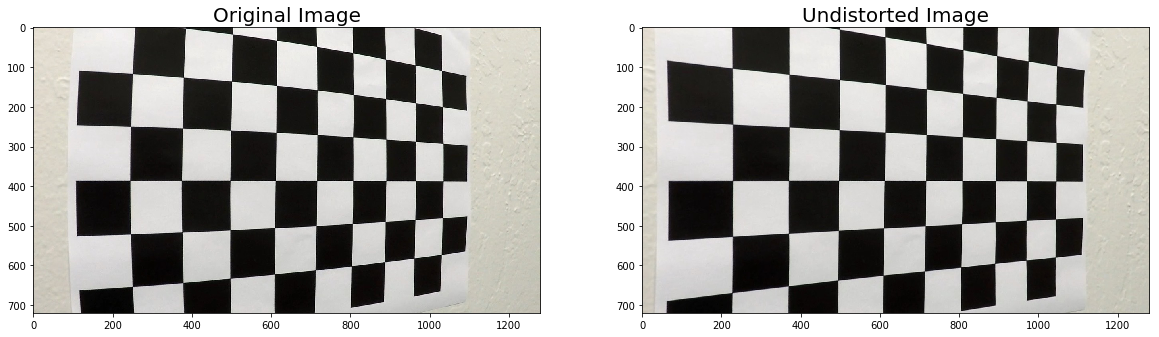

In [4]:
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

# Apply a distortion correction to an image
img_cali_dst = undistort(img_cali_src)
cv2.imwrite('camera_calibration/calibration_undist.jpg', cv2.cvtColor(img_cali_dst, cv2.COLOR_RGB2BGR))

# Visualize undistortion
visualize(img_cali_src, img_cali_dst, 'Undistorted Image')

# Pipeline (image)

## 1. Distortion correction

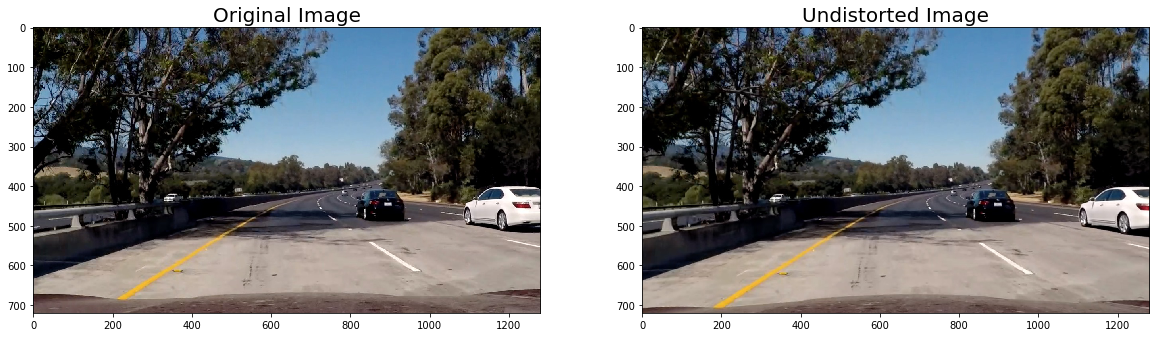

In [5]:
img_test = mpimg.imread('pipeline/test_image.jpg')

# Apply a distortion correction to an image
img_test_undistort = undistort(img_test)
cv2.imwrite('pipeline/test_image_undist.jpg', cv2.cvtColor(img_test_undistort, cv2.COLOR_RGB2BGR))

# Visualize undistortion
visualize(img_test, img_test_undistort, 'Undistorted Image')

## 2. Color and gradient threshold 

In [6]:
# Calculate directional gradient, ref #21
def abs_sobel_thresh(img_gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)   
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    param3 = 1 if orient == 'x' else 0
    param4 = 1 if orient == 'y' else 0
    #img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    sobel = cv2.Sobel(img_gray, cv2.CV_64F, param3, param4) 
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    
    return binary_output


# Calculate gradient magnitude, ref #22    
def mag_thresh(img_gray, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    abs_sobel = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


# Calculate gradient direction, ref #23
def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # ...
    return binary_output


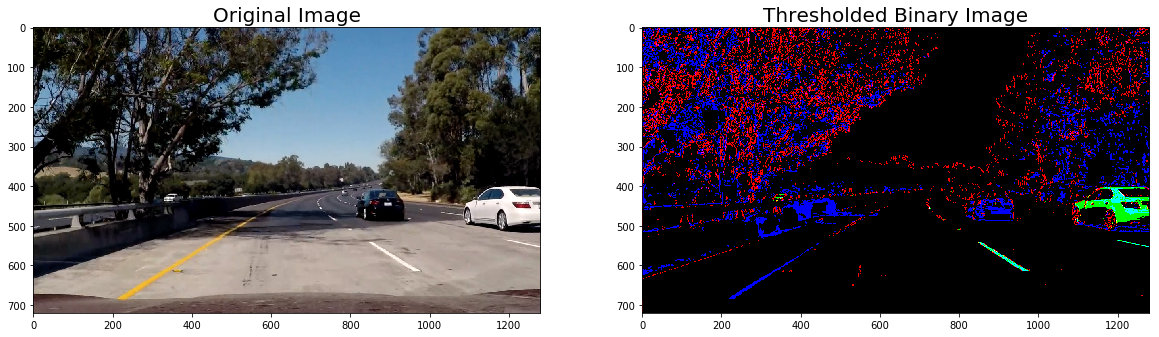

In [7]:
x_thresh=(30, 90)
g_thresh=(220, 255)
s_thresh=(200, 255)
#r_thresh=(200, 255)

def threshold(img, is_color_binary = False):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    #r_channel = img[:,:,0]
    
    # Threshold x gradient (red)
    x_binary = abs_sobel_thresh(gray, 'x', 3, thresh=x_thresh)
    
    # Threshold gray (green)
    g_binary = np.zeros_like(gray)
    g_binary[(gray >= g_thresh[0]) & (gray <= g_thresh[1])] = 1
    # Threshold color channel S (blue)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack channels with RGB colors
    color_binary = np.dstack((x_binary, g_binary, s_binary))
    # Combine channels
    combined_binary = np.zeros_like(g_binary)
    combined_binary[(x_binary == 1) | (g_binary == 1) | (s_binary == 1)] = 1
    
    img_binary = combined_binary if is_color_binary == False else color_binary
    return img_binary


img_test_threshold = threshold(img_test, True)

# Visualize the result
visualize(img_test, img_test_threshold, 'Thresholded Binary Image', 'Original Image', 'gray')

## 3. Perspective transform

In [8]:
img_line = mpimg.imread("pipeline/straight_lines2.jpg")
img_size = (img_line.shape[1], img_line.shape[0])

# Apply a distortion correction to an image
img_line_undistort = undistort(img_line)
cv2.imwrite('pipeline/straight_lines_undist.jpg', cv2.cvtColor(img_line_undistort, cv2.COLOR_RGB2BGR))

# Read in the saved camera matrix and distortion coefficients
#dist_pickle = pickle.load(open("camera_calibration/calibration_result.p", "rb" ))
#mtx = dist_pickle["mtx"]
#dist = dist_pickle["dist"]

# Select 4 source and destination coord points manually as stated in the video of [ref #15]
pt_lt = [ 588, 455]#[ 595, 450]
pt_rt = [ 695, 455]#[ 690, 450]
pt_rb = [1075, 700]#[1045, 680]
pt_lb = [ 245, 700]#[ 273, 680]

pts_src = np.float32((
    pt_lt, pt_rt,
    pt_rb, pt_lb
))
pts_dst = np.float32((
    [pt_lb[0], 0], [pt_rb[0], 0],
    [pt_rb[0], img_size[1]], [pt_lb[0], img_size[1]]
))

# Compute the perspective transform M with the defined points
M = cv2.getPerspectiveTransform(pts_src, pts_dst)

# Compute the inverse perspective transform (for later usage)
Minv = cv2.getPerspectiveTransform(pts_dst, pts_src)

def transform(image):
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

def transformInverse(image):
    return cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)


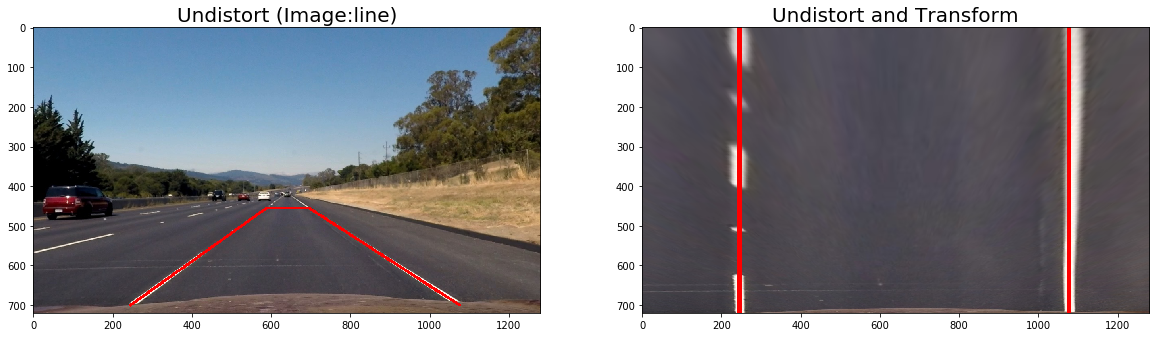

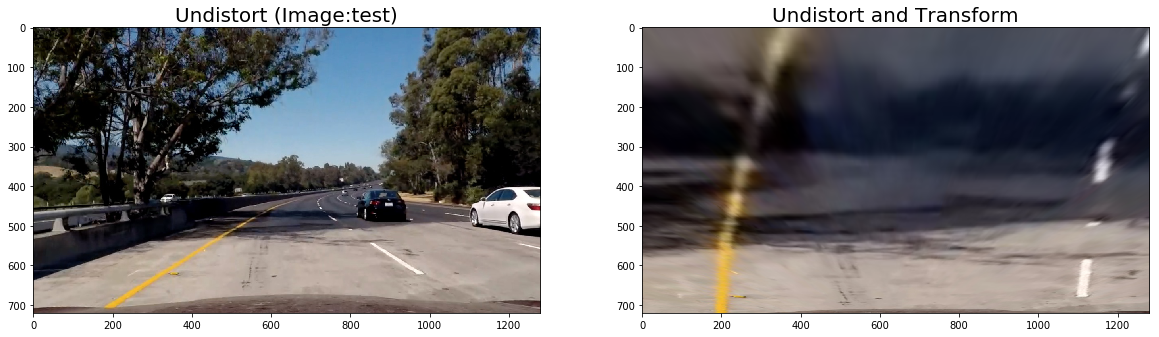

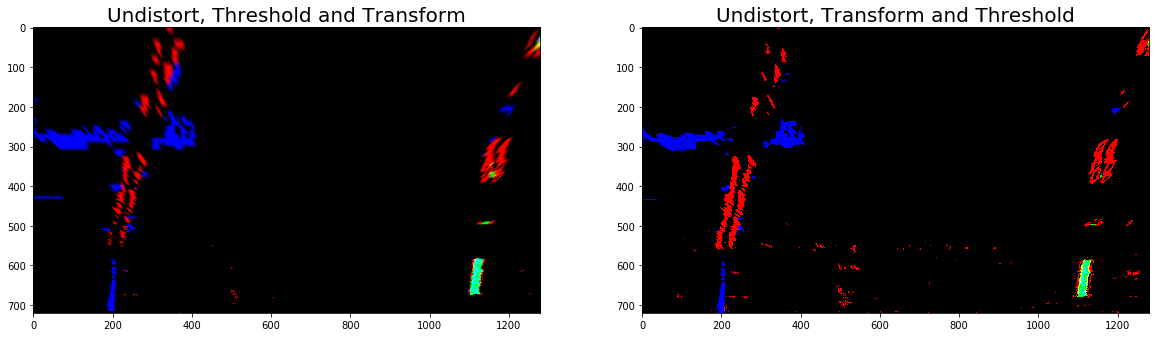

In [9]:
# Warp an image using the perspective transform M
img_line_transform = transform(img_line_undistort)

img_test_transform = transform(img_test_undistort)
img_test_transform_threshold = threshold(img_test_transform, True)
img_test_threshold_transform = transform(img_test_threshold)

# Visualize undistorted and Warped Image
lines = np.array([pt_lb, pt_lt, pt_rt, pt_rb], np.int32)
cv2.polylines(img_line_undistort, [lines], False, (255, 0, 0), 5)

# TODO: copy and two layers
cv2.line(img_line_transform, (pt_lb[0], 0), (pt_lb[0], img_size[1]), (255, 0, 0), 10)
cv2.line(img_line_transform, (pt_rb[0], 0), (pt_rb[0], img_size[1]), (255, 0, 0), 10)

visualize(img_line_undistort, img_line_transform, 'Undistort and Transform', 'Undistort (Image:line)')
visualize(img_test_undistort, img_test_transform, 'Undistort and Transform', 'Undistort (Image:test)')
visualize(img_test_threshold_transform, img_test_transform_threshold, 'Undistort, Transform and Threshold', 'Undistort, Threshold and Transform', 'gray', 'gray')

## 4. Detect lane lines

### Method histogram

In [10]:
### Implement Sliding Windows and Fit a Polynomial

def find_lines_histogram(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    img_find_line = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(img_find_line,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,128,0), -1) 
        cv2.rectangle(img_find_line,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,128,0),-1) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    img_find_line[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 255, 0]
    img_find_line[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 255, 0]
    
    return img_find_line, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty

def plot_lines_histogram(img_find_line):    
    plt.imshow(img_find_line)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, img_size[0])#1280)
    plt.ylim(img_size[1], 0)#720, 0)
    

def find_lines_express(binary_warped, left_fit, right_fit):
    ### Skip the sliding windows step once you know where the lines are
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    # Visualize
    # Create an image to draw on and an image to show the selection window
    img_find_line = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(img_find_line)
    # Color in left and right line pixels
    img_find_line[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 255, 0]
    img_find_line[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 255, 0]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    img_find_line_exp = cv2.addWeighted(img_find_line, 1, window_img, 0.3, 0)
    
    return img_find_line_exp, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty

def plot_lines_express(img_find_line_exp, left_fitx, right_fitx, ploty):
    plt.imshow(img_find_line_exp)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, img_size[0])
    plt.ylim(img_size[1], 0)
  

### Method convolution

In [11]:
### implement sliding window with a convolution

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


def find_lines_convolution(warped):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:
        #print(window_centroids)

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

        
    # Visualize    
    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    

### Tests

In [12]:
# Read in a thresholded image
img_warped = threshold(img_test_transform, False)
warped = np.zeros_like(img_warped)
warped[(img_warped == 1)] = 255
#print(warped)

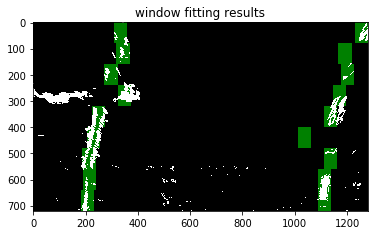

In [13]:
### Apply method convolution
find_lines_convolution(warped)

/Users/achan-fardel/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


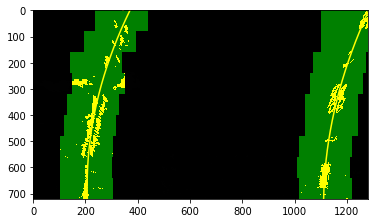

In [14]:
### Apply method histogram
#find_lines_histogram(img_test_undistorted_transformed)
img_find_line, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = find_lines_histogram(warped)
plot_lines_histogram(img_find_line)

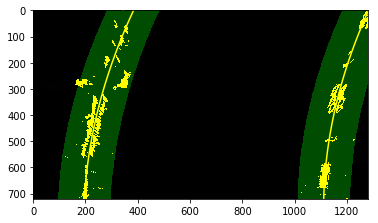

In [15]:
### Apply method histogram with skip search
img_find_line_exp, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = find_lines_express(warped, left_fit, right_fit)
plot_lines_express(img_find_line_exp, left_fitx, right_fitx, ploty)

## 5. Determine the lane curvature

In [16]:
### Calculate the radius of curvature after correcting for scale in x and y
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def curvature(leftx, lefty, rightx, righty):
    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x, y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radius of curvature in meters
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    sort_curverads = np.sort([left_curverad, right_curverad])
    diff_curverads = sort_curverads[1]/sort_curverads[0]
    return left_curverad, right_curverad, diff_curverads

left_curverad, right_curverad, diff_curverads = curvature(leftx, lefty, rightx, righty)
print("curve value:", left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

curve value: 575.317103863 m 556.045465392 m


## 6. Project back down onto the road

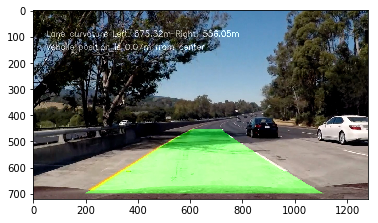

In [17]:
def plot_back(image, warped, left_fitx, right_fitx, ploty, left_curverad, right_curverad, is_reset=False, reset_left_curverad=left_curverad, reset_right_curverad=right_curverad):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    warp_rect = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_rect, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_warp = transformInverse(warp_rect) 
    
    # Combine the result with the original image
    c_car = (right_fitx[-1] + left_fitx[-1]) / 2
    c_lane = img_size[0]/2
    distance = round((c_car-c_lane)*xm_per_pix*100)/100
    text1 = 'Vehcile position is {:.2f}m from center'.format(distance)
    text2 = 'Lane curvature {} {:5.2f}m {} {:5.2f}m'.format("Left:", left_curverad, "Right:", right_curverad) 
    cv2.putText(img_warp, text1, (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(img_warp, text2, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    if is_reset:
        #text3 = '                {} {:5.2f}m {} {:5.2f}m {}'.format("Left:", reset_left_curverad, "Right:", reset_right_curverad, "(Reset!)")
        cv2.putText(img_warp, "Reset!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    img_plot_back = cv2.addWeighted(image, 1, img_warp, 0.5, 0)
    
    return img_plot_back

img_plot_back = plot_back(img_test, warped, left_fitx, right_fitx, ploty, left_curverad, right_curverad)
plt.imshow(img_plot_back)

## Pipeline and test images

/Users/achan-fardel/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


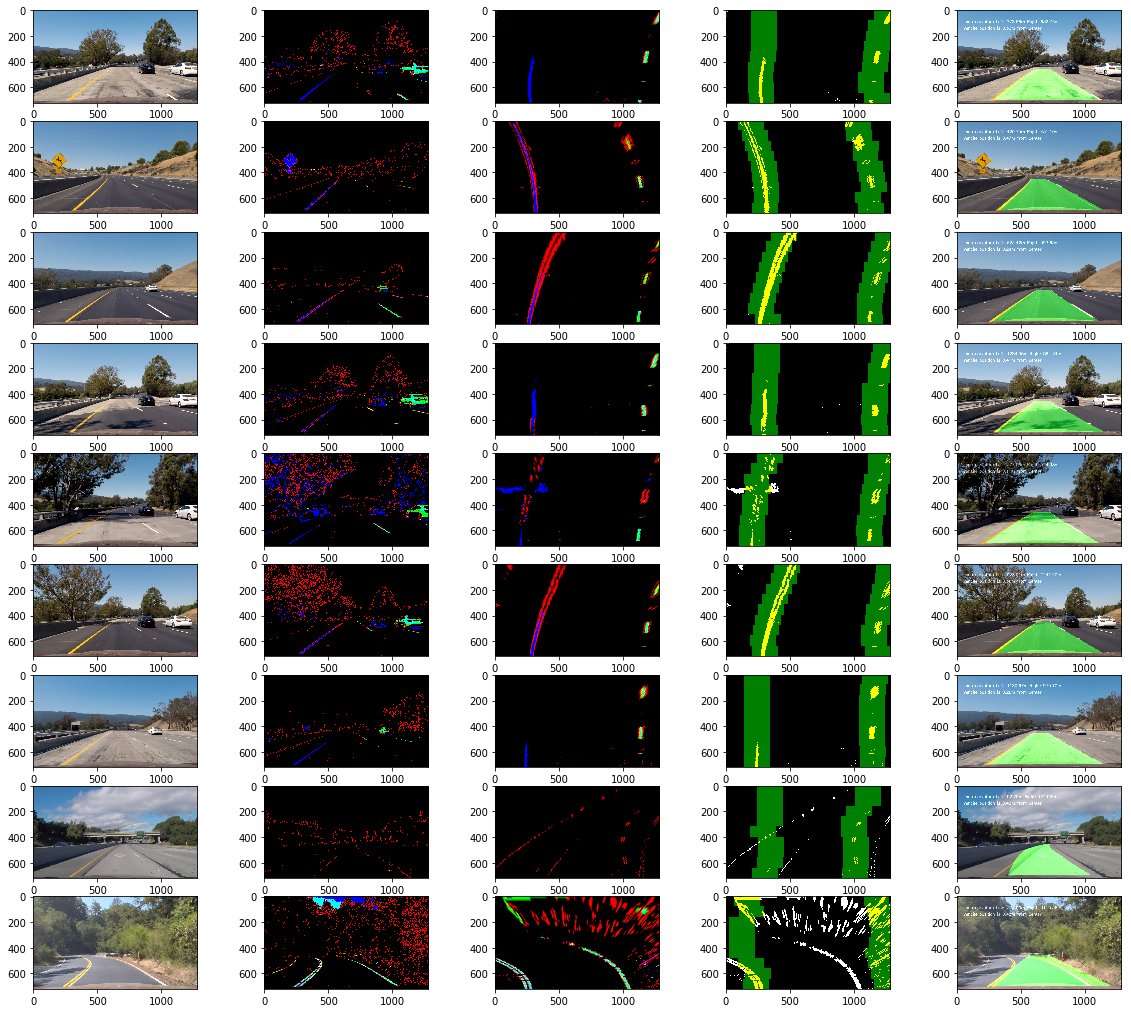

In [18]:
### Create Pipeline
reset_left_fitx = None
reset_right_fitx = None
reset_ploty = None
reset_left_curverad = 500
reset_right_curverad = 500
reset = False

def pipeline(image, is_video=False):
    # 1. undistort
    img_undistort = undistort(image)
    # 2. threshold
    img_threshold_stacked = threshold(img_undistort, True)
    img_threshold = threshold(img_undistort)
    # 3. transform
    img_transform_stacked = transform(img_threshold_stacked)
    img_transform = transform(img_threshold)
    # 4. find lines
    img_find_line, left_fit, right_fit, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = find_lines_histogram(img_transform)   
    
    # 5. curvature
    left_curverad, right_curverad, diff_curverads = curvature(leftx, lefty, rightx, righty)
    
    # check values are a) not too small and b) not too far from parallel
    global reset_left_fitx, reset_right_fitx, reset_ploty, reset_left_curverad, reset_right_curverad
    is_makesense_and_roughlystraight = left_curverad > 1250 and right_curverad > 1250
    is_makesense_and_roughlyparallel = left_curverad > 275 and right_curverad > 275 and diff_curverads < 2.25
    is_jump = abs(left_curverad - reset_left_curverad) > 750 and abs(right_curverad - reset_right_curverad) > 750
    if not is_video or is_makesense_and_roughlystraight or (is_makesense_and_roughlyparallel and not is_jump):
        reset_left_fitx = left_fitx
        reset_right_fitx = right_fitx
        reset_ploty = ploty
        reset = False
        #print(left_curverad, right_curverad, diff_curverads)
    else:
        left_fitx = reset_left_fitx
        right_fitx = reset_right_fitx
        ploty = reset_ploty
        reset = True
        #print(left_curverad, right_curverad, diff_curverads, "(original)")
        #print(reset_left_curverad, reset_right_curverad, "(replaced)")
    reset_left_curverad = left_curverad
    reset_right_curverad = right_curverad
        
    # 6. plot back
    img_plot_back = plot_back(img_undistort, img_transform, left_fitx, right_fitx, ploty, left_curverad, right_curverad, reset, reset_left_curverad, reset_right_curverad)
    
    images = [img_undistort, img_threshold_stacked, img_transform_stacked, img_find_line, img_plot_back]
    return images


### Test images
fns = glob.glob('pipeline/test_images/test*.jpg')
cmaps = [None, 'gray', 'gray', None, None]

n_col = 5
n_fns = len(fns)*n_col
n_row = math.ceil(n_fns/n_col)

plt.figure(n_fns, figsize=(20, 18))
for index, fname in enumerate(fns):
    image = mpimg.imread(fname)
    images = pipeline(image)
    
    for idx, img in enumerate(images):
        plt.subplot(n_row, n_col, index*n_col+idx+1)
        plt.imshow(img, cmap=cmaps[idx])
    

# Pipeline (video)

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time
ts = str(int(time.time()))

def process_image(image):
    images = pipeline(image, is_video=True)
    return images[4]


In [20]:
# process
video_flname1 = 'project_video'
video_output1 = 'output_videos/' + ts + '_' + video_flname1 + '_output.mp4'
clip1 = VideoFileClip('videos/' + video_flname1 + '.mp4')
video_clip1 = clip1.fl_image(process_image)
%time video_clip1.write_videofile(video_output1, audio=False)
    
# display
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(video_output1))

[MoviePy] >>>> Building video output_videos/1493712848_project_video_output.mp4
[MoviePy] Writing video output_videos/1493712848_project_video_output.mp4


100%|█████████▉| 1260/1261 [03:42<00:00,  5.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/1493712848_project_video_output.mp4 

CPU times: user 4min 38s, sys: 59.3 s, total: 5min 38s
Wall time: 3min 43s


In [21]:
# process
#video_flname2 = 'challenge_video'
#video_output2 = 'output_videos/' + ts + '_' + video_flname2 + '_output.mp4'
#clip2 = VideoFileClip('videos/' + video_flname2 + '.mp4')
#video_clip2 = clip2.fl_image(process_image)
#%time video_clip2.write_videofile(video_output2, audio=False)

# display
#HTML("""
#<video width="640" height="360" controls>
#  <source src="{0}">
#</video>
#""".format(video_output2))

In [22]:
# process
#video_flname3 = 'harder_challenge_video'
#video_output3 = 'output_videos/' + ts + '_' + video_flname3 + '_output.mp4'
#clip3 = VideoFileClip('videos/' + video_flname3 + '.mp4')
#video_clip3 = clip3.fl_image(process_image)
#%time video_clip3.write_videofile(video_output3, audio=False)

# display
#HTML("""
#<video width="640" height="360" controls>
#  <source src="{0}">
#</video>
#""".format(video_output3))